## Goals & Approach

The goal of this kernel is to generate some useful insights into job postings by City of Los Angeles, by following the steps below. 

* Convert a folder full of plain-text job postings into a single structured CSV file and then to use this data to: 
    * Identify language that can negatively bias the pool of applicants; 
    * Improve the diversity and quality of the applicant pool; and/or 
    * Make it easier to determine which promotions are available to employees in each job class.

### Approach:
We will proeed in this order. 
1. Data Cleaning / Dataframe generation
2. Exploratory Analysis / Visualization
3. Recommendations


## Data Cleaning / Dataframe generation

**Columns Added So Far: (More to be added)**

**NOTE:** Please refer to the file named "kaggle_data_dictionary.csv" for the descriptions of various columns.
* FILE_NAME
* JOB_CLASS_TITLE
* JOB_CLASS_NO
* JOB_DUTIES
* REQUIREMENTS (Not sorted into SET_ID / SUBSET_ID yet)
* ENTRY_SALARY_GEN
* ENTRY_SALARY_DWP
* OPEN_DATE
* DRIVER_LICENSE_REQ
* DRIV_LIC_TYPE

In [1]:
# This block imports necessary libraries

import numpy as np # linear algebra
import scipy as sp
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random

warnings.filterwarnings('ignore')

### The function below reads a single job posting and generates a single row of a dataframe with relevant fields. 

In [2]:
# Function to read a single job posting
def read_job_posting(filename):
    # read all the files into memory
    with open(filename, 'r', errors='ignore') as fp:
        filetext = fp.readlines()
        filetext = [line.rstrip().replace('\t+','') for line in filetext if line.rstrip()]
    # concatenated file text
    concat_file_text = '\n'.join(filetext)
    
    # Extract Various Fields
    this_file_data = {'FILE_NAME': os.path.basename(filename),
                      'FILE_TEXT':concat_file_text,
                      'JOB_CLASS_TITLE':filetext[0].rstrip(),
                      'JOB_CLASS_NO': (re.findall(r'\d+',list(filter(lambda x: 'Class Code:' in x,filetext))[0])[0] 
                                       if len(list(filter(lambda x: 'Class Code:' in x,filetext))) > 0 else np.nan),
                      'OPEN_DATE': (list(filter(lambda x: 'Open Date:' in x,filetext))[0].split("Open Date:")[1].split("(")[0].strip() 
                                    if len(list(filter(lambda x: 'Open Date:' in x,filetext))) >0 else None),
                      'JOB_DUTIES': re.split(r'DUTIES\n*|\n*REQUIREMENT',concat_file_text)[1],
                      'ENTRY_SALARY_GEN': (re.split(r'\n+|;|and|or|The|\(|\. |, ',
                                                   re.split(r'ANNUAL SALARY\n*',concat_file_text)[1])[0]
                                                      .strip().replace('to','-').replace('TO','-').replace('flat rated.','(flat rated)') 
                                           if len(re.split(r'ANNUAL SALARY\n*',concat_file_text)) > 1 else None),
                      'ENTRY_SALARY_DWP': (re.split(r'\n+|;|and|or|The|\(|\. , ',(list(filter(lambda x: 'salary in the Department of Water and Power is' in x,filetext))[0]
                                            .split('Power is')[1]))[0]
                                            .strip().replace('to','-')
                                            .replace('flat rated.','(flat rated)') 
                                           if len(list(filter(lambda x: 'salary in the Department of Water and Power is' in x,filetext))) > 0 else np.nan),
                      'REQUIREMENTS': (re.split(r'\n*WHERE TO APPLY',(re.split(r'REQUIREMENTS?(?:\s*/\s*MINIMUM QUALIFICATIONS?)?\n*',concat_file_text)[1]))[0]
                                       if len(re.split(r'REQUIREMENTS?(?:\s*/\s*MINIMUM QUALIFICATIONS?)?',concat_file_text)) > 1 else None),
                     }
    # ENTRY_SALARY_GEN
    if this_file_data['ENTRY_SALARY_GEN'] is not None:
        if '$' not in this_file_data['ENTRY_SALARY_GEN']:
            this_file_data['ENTRY_SALARY_GEN'] = None
    try: 
        this_file_data['ENTRY_SALARY_AVG'] = (np.mean(list(map(float,re.sub('\$|,|\(*flat.*rated\)*|-|\*','',this_file_data['ENTRY_SALARY_GEN']).split()))))
    except Exception as e:
        this_file_data['ENTRY_SALARY_AVG'] = np.nan #if this_file_data['ENTRY_SALARY_GEN'] is not None else np.nan)                              

    
    if 'driver\'s license is required' in this_file_data['REQUIREMENTS']:
        this_file_data['DRIVER_LICENSE_REQ'] = 'R'
    elif re.compile('driver\'s license').search(this_file_data['REQUIREMENTS']):
        this_file_data['DRIVER_LICENSE_REQ'] = 'P'
    else:
        this_file_data['DRIVER_LICENSE_REQ'] = ''
     
    df = pd.DataFrame(this_file_data, index=[0])
    df['DRIV_LIC_TYPE'] = df.REQUIREMENTS.str.extract(r'(Class.*)\s+(driver\'s)\s*license?')[0].str.replace('\s*(driver\'s)?\s*license.*|\s*California\s*','')
   
    return(df)

### Let us read all the job postings into a dataframe using the function above.

In [3]:
bulletin_dir = "../input/cityofla/CityofLA/Job Bulletins"
print('Reading: '+ bulletin_dir)

filenames = glob.glob(bulletin_dir+'/*')
data_list = []
for file_ in filenames:
    df = read_job_posting(file_)
    data_list.append(df)
        
df_jobs = pd.concat(data_list, sort = False).reset_index(drop = True)
#df_jobs.head(10)
#set(df_jobs.DRIV_LIC_TYPE)

Reading: ../input/cityofla/CityofLA/Job Bulletins


### Let us display 15 randomly selected rows of the dataframe, that we painstakingly built. You can scroll left and right to see all the columns.

In [ ]:
df_jobs.loc[random.sample(list(df_jobs.index),15),]

## Data Analysis / Visualization

### Let us start with the distribution of salaries (middle of the range) in the job postings

In [ ]:
sns.set()
plt.rcParams['figure.figsize']=(12,6)
sns.distplot(df_jobs.ENTRY_SALARY_AVG.fillna(axis=0, method='ffill'), bins =30, color = 'red')

** It looks the salaries are peaking at around \$80,000. But there are some jobs with more than \$250,000 salary !!**

## Word Cloud of the Requirement Column

Let us turn the words from the Job Requirements column in to a word coud to see if any words stand out. 

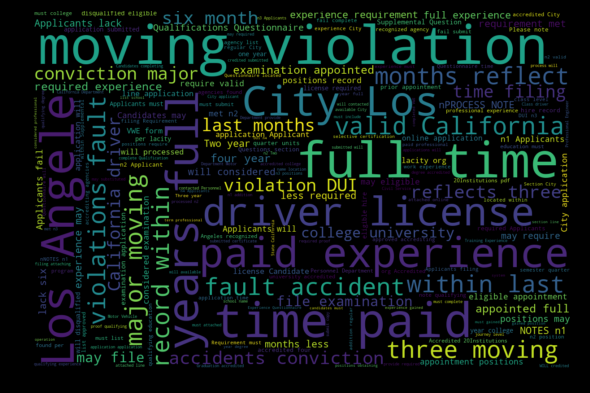

In [8]:
from wordcloud import WordCloud, STOPWORDS
text = df_jobs.REQUIREMENTS.values
wordcloud = WordCloud(
    width = 1200,
    height = 800,
    background_color = 'black').generate(str(text))
fig = plt.figure(
    figsize = (8, 6),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


### Observataions from above

1. Apart from the obvious items such as "Los Angeles", text related to traffic citations and driver license requirements show up a lot in the job postings. Given how important these are, it is probably worth it to pust a more structured requirements for the Driver License than a free from text description. 

# Suggestions for Improving the Job Postings

1. Given how frequently Driver License requirements are mentioned in the job postings, it is probably worth it to pust a more structured requirements for the Driver License than a free from text description. It is probably also good to mention clearly if a driver license requirement not there for a job. 

2. It is probably more useful to have a section of "Disqualifying Conditions", so that it is easier for the candidates to filter out the jobs that have that disqualifying criteria such as "having 3 citations in the past 3 years etc."